# Initialize Laserscanner

In [5]:
# [X] laser callback function
# [X] laser init variable 
# [X] downsampling 
# [X] safe laserscan info 
# [X] MODE 1: box-downsampling
# [X] MODE 2: uniform-downsampling: check for invalid measurements -> m is valid if: min_range < m < max_range and num_uniform_beams


# hokuyo 20 lx specs
# angle_min: -2.356194496154785
# angle_max: 2.356194496154785
# angle_increment: 0.004363323096185923
# time_increment: 1.736111516947858e-05
# scan_time: 0.02500000037252903
# range_min: 0.019999999552965164
# range_max: 60.0

In [ ]:
from sensor_msgs.msg import LaserScan

lidar_initialized = False
num_beams = None
angle_min = None
angle_max = None 

def lidar_cb(msg: LaserScan):
    # initialize laser scan params like range_min, ...
    if not lidar_initialized:
        num_beams = len(msg.ranges)
        angle_min = msg.angle_min
        angle_max = msg.angle_max
        range_max = msg.range_max # only if parameter range_max = -1 
        range_min = msg.range_min # only if parameter range_min = -1
    
    # extract ranges
    ranges = msg.ranges
    
    # initialize
    lidar_initialized = True

In [ ]:
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Quaternion

odom = Odometry()
odom.pose.pose.orientation.w = 0.5
odom.pose.pose.orientation.y = 0.0
odom.pose.pose.orientation.z = 0.5
odom.pose.pose.orientation.x = 0.0

from tf_transformations import euler_from_quaternion


orientation: list = odom.pose.pose.orientation
print(euler_from_quaternion(orientation))


TypeError: cannot unpack non-iterable Quaternion object

### Box downsampling

[   0   18   51   92  139  190  241  286  324  355  380  400  416  429
  440  449  457  464  470  475  482  496  511  526  540  554  569  584
  598  605  610  616  623  631  640  651  664  680  700  725  756  794
  839  890  941  988 1029 1062 1080]


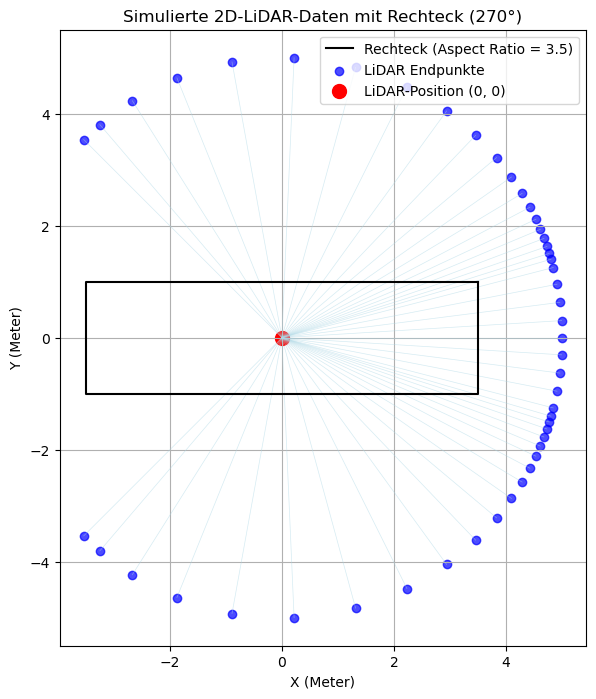

In [1]:
import numpy as np

range_min = 5.0
range_max = 5.0
angle_min = -2.356194496154785
angle_max = +2.356194496154785
num_beams = 1081
des_beams = 50 # desired number of beams -> more precise variable name
lidar_aspect_ratio = 3.5
angle_deg = 270

def get_boxed_indices():
    '''
    Finds an evenly spaced "boxed" pattern of beams based on the TUM paper
    "ROS-based localization of a race vehicle at high-speed using LIDAR".
    '''
    beam_angles = np.linspace(
        angle_min, angle_max, num_beams)

    MID_IDX = num_beams//2
    sparse_idxs = [MID_IDX]

    # Structures
    a = lidar_aspect_ratio
    beam_proj = 2*a*np.array([np.cos(beam_angles), np.sin(beam_angles)])
    # Allows us to do intersection math later
    beam_intersections = np.zeros((2, num_beams))

    # Compute the points of intersection along a uniform corridor of given aspect ratio
    box_corners = [(a, 1), (a, -1), (-a, -1), (-a, 1)]
    for idx in range(len(box_corners)):
        x1, y1 = box_corners[idx]
        x2, y2 = box_corners[0] if idx == 3 else box_corners[idx+1]
        for i in range(num_beams):
            x4 = beam_proj[0, i]
            y4 = beam_proj[1, i]

            den = (x1-x2)*(-y4)-(y1-y2)*(-x4)
            if den == 0:
                continue    # parallel lines

            t = ((x1)*(-y4)-(y1)*(-x4))/den
            u = ((x1)*(y1-y2)-(y1)*(x1-x2))/den

            px = u*x4
            py = u*y4
            if 0 <= t <= 1.0 and 0 <= u <= 1.0:
                beam_intersections[0, i] = px
                beam_intersections[1, i] = py

    # Compute the distances for uniform spacing
    dx = np.diff(beam_intersections[0, :])
    dy = np.diff(beam_intersections[1, :])
    dist = np.sqrt(dx**2 + dy**2)
    total_dist = np.sum(dist)
    dist_amt = total_dist/(des_beams-1)
    # rospy.loginfo(f"{dist.shape=}, {total_dist=:.2f}, {dist_amt=:.2f}")

    # Calc half of the evenly-spaced interval first, then the other half
    idx = MID_IDX + 1
    DES_BEAMS2 = des_beams//2 + 1
    acc = 0
    while len(sparse_idxs) <= DES_BEAMS2:
        acc += dist[idx]
        if acc >= dist_amt:
            acc = 0
            sparse_idxs.append(idx-1)
        idx += 1

        if idx == num_beams-1:
            sparse_idxs.append(num_beams-1)
            break

    mirrored_half = []
    for idx in sparse_idxs[1:]:
        new_idx = 2*sparse_idxs[0]-idx
        mirrored_half.insert(0, new_idx)
    sparse_idxs = mirrored_half + sparse_idxs

    # results 
    lidar_sample_idxs = np.array(sparse_idxs)
    lidar_theta_lut = beam_angles[lidar_sample_idxs]
    lidar_theta_lut = lidar_theta_lut.astype(np.single)
    return lidar_sample_idxs
    # self.LIDAR_SAMPLE_IDXS = np.array(sparse_idxs)
    # self.LIDAR_THETA_LUT = beam_angles[self.LIDAR_SAMPLE_IDXS]
    # self.LIDAR_THETA_LUT = self.LIDAR_THETA_LUT.astype(np.single)
    
    
def simulate_lidar_2d(range_min, range_max, num_beams, angle_deg):

    """

    Simuliert einen 2D-Laserscanner mit bestimmten Parametern.



    :param range_min: Mindestreichweite des Scanners (m)

    :param range_max: Maximalreichweite des Scanners (m)

    :param num_beams: Anzahl der Laserstrahlen

    :param angle_deg: Winkelbereich des Scanners (in Grad)

    :return: x- und y-Koordinaten der simulierten LiDAR-Daten

    """

    # Winkelbereich in Radiant

    angle_rad = np.radians(angle_deg)

    angles = np.linspace(-angle_rad / 2, angle_rad / 2, num_beams)



    # Zufällige Reichweiten

    ranges = np.random.uniform(range_min, range_max, num_beams)



    # Umrechnung in kartesische Koordinaten

    x = ranges * np.cos(angles)

    y = ranges * np.sin(angles)

    return x, y, angles, ranges

x,y,angles,ranges = simulate_lidar_2d(range_min, range_max, num_beams, angle_deg)

theta_LUT = get_boxed_indices()
print(theta_LUT)

x = x[theta_LUT]
y = y[theta_LUT]
angles = angles[theta_LUT]
ranges = ranges[theta_LUT]

import matplotlib.pyplot as plt

# Rechteck um den LiDAR definieren
a = lidar_aspect_ratio
box_corners = [(a, 1), (a, -1), (-a, -1), (-a, 1), (a, 1)]

# Plot erstellen
plt.figure(figsize=(8, 8))

# LiDAR-Linien plotten
for i in range(len(x)):
    plt.plot([0, x[i]], [0, y[i]], color='lightblue', alpha=0.5, linewidth=0.5)

# Rechteck um den Scanner plotten
box_x, box_y = zip(*box_corners)
plt.plot(box_x, box_y, 'k-', label=f"Rechteck (Aspect Ratio = {lidar_aspect_ratio})")

# Punkte der LiDAR-Enden hinzufügen
plt.scatter(x, y, c='b', alpha=0.7, label="LiDAR Endpunkte")
plt.scatter(0, 0, c='r', label="LiDAR-Position (0, 0)", s=100)  # Punkt (0, 0) hinzufügen

plt.gca().set_aspect('equal', adjustable='box')
plt.title("Simulierte 2D-LiDAR-Daten mit Rechteck (270°)")
plt.xlabel("X (Meter)")
plt.ylabel("Y (Meter)")
plt.grid(True)
plt.legend()
plt.show()